In [427]:
import torch
import numpy as np
from torch import nn, optim
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold
import torch.nn.functional as F
import torchvision

from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, precision_recall_curve, average_precision_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
cuda = torch.cuda.is_available()
if cuda:
    device = "cuda"
    print("cuda available")
torch.cuda.get_device_name(0)    

cuda available


'Quadro M1000M'

In [399]:
%%time
df_train = pd.read_csv('train.csv.zip')
df_test = pd.read_csv('test.csv.zip')

Wall time: 54.6 s


In [400]:
train_cols = [col for col in df_train.columns if col not in ['ID_code', 'target']]
y_train = df_train['target']

In [401]:
df_train.shape

(200000, 202)

In [402]:
ss = StandardScaler()
rs = RobustScaler() 
df_train[train_cols] = ss.fit_transform(df_train[train_cols])
df_test[train_cols] = ss.fit_transform(df_test[train_cols])

In [403]:
df_train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,-0.577102,-1.273737,0.451707,-0.833709,0.235571,-0.536430,-0.334926,0.608751,...,0.263374,-1.149158,0.817469,-0.411013,0.168705,-1.578117,1.022131,-0.373968,-1.026398,0.214135
1,train_1,0,0.269959,-0.622138,1.190360,-0.688846,0.790975,1.539900,0.244461,-0.003525,...,0.966611,0.093605,0.443623,1.908764,-0.817594,1.522342,1.067654,-0.129400,0.825417,0.505685
2,train_2,0,-0.681113,-0.276066,0.516988,0.536516,-0.305477,-0.511033,1.769839,-0.564749,...,-0.072093,0.777997,-0.174131,-0.412316,1.151591,2.297370,-1.617906,-0.695141,-0.381449,0.356681
3,train_3,0,0.125158,-0.129426,-0.667575,0.195355,0.927992,0.410672,0.500633,-0.474201,...,0.270216,-0.891456,-0.818468,-0.478548,1.607869,-0.789517,-0.959020,1.501744,0.697118,-0.543502
4,train_4,0,-0.277303,0.035610,0.817683,-0.077829,0.738607,0.955574,0.613372,0.791544,...,-1.036191,0.688988,-1.405987,1.468536,-1.501101,-0.958473,0.297627,0.645537,0.706318,-0.525375


In [379]:
class classifier(nn.Module):
    
    def __init__(self, hidden_dim, dropout = 0.3):
        super().__init__()
        
        self.fc1 = nn.Linear(200, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(p = dropout)
    
    
    def forward(self,x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x   

In [380]:
model = classifier(100)
print(model)
del model

classifier(
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)


In [203]:
batch_size = 1000

train_x = torch.from_numpy(df_train[train_cols].values).float().cuda()
train_y = torch.from_numpy(y_train.values).float().cuda()

test_x = torch.from_numpy(df_test[train_cols].values).float().cuda()

In [204]:
type(train_x)

torch.Tensor

In [205]:
train_x_dataset = torch.utils.data.TensorDataset(train_x, train_y)
# te_x_dataset = torch.utils.data.TensorDataset(te_x)

In [206]:
trainloader = torch.utils.data.DataLoader(train_x_dataset, batch_size = batch_size, shuffle = True)

In [447]:
model = classifier(100)
model.cuda()
optimizer = optim.SGD(model.parameters(), lr = 0.005)
# criterion = nn.CrossEntropyLoss() # also number of outputs should be 2
criterion = nn.BCEWithLogitsLoss()
print(model)

classifier(
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)


In [448]:
x,y = next(iter(trainloader))

In [449]:
x

tensor([[ 0.2651, -0.0782, -0.6425,  ...,  1.0954,  1.4456, -1.4608],
        [-0.2241, -0.4485, -0.9721,  ...,  0.1203, -0.8118, -1.2728],
        [ 0.9425,  0.3757, -0.2364,  ...,  0.0755, -0.1102,  0.4335],
        ...,
        [-0.3833, -1.3038,  0.6323,  ..., -0.1134,  0.7703,  1.1388],
        [-1.3360, -0.8418,  0.6823,  ...,  0.0901, -0.5293,  1.5723],
        [ 0.9403,  0.9838,  1.2544,  ..., -0.3421, -0.8356,  1.4559]],
       device='cuda:0')

In [450]:
x.shape, x.view(x.shape[0],1,-1).shape, y.shape, y.view(-1,1).shape

(torch.Size([1000, 200]),
 torch.Size([1000, 1, 200]),
 torch.Size([1000]),
 torch.Size([1000, 1]))

In [451]:
o = model(x)
l = criterion(o, y.view(-1,1))
l

tensor(0.7336, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

In [232]:
epochs = 2
train_losses, test_losses = [],[]

for e in range(epochs):
    running_loss = 0
    for step, (x_batch,y_batch) in enumerate(trainloader):
        optimizer.zero_grad()
#         print(step)
#         print(x_batch)
#         print(y_batch)
        
        model.train()
        output = model(x_batch)
        loss = criterion(output, y_batch.view(-1,1))
        loss.backward()
        optimizer.step()
        running_loss += loss
        
        if step % 100 ==0:
            print(running_loss.item())
        
    train_losses.append(running_loss.item())    

print(train_losses)        

0.49123233556747437
0.4669589400291443
[12.237966537475586, 11.555702209472656]


In [216]:
with torch.no_grad():
    model.eval()

    pred_y = model(test_x)
    print(pred_y.shape)

torch.Size([25000, 1])


In [217]:
pred_y

tensor([[-0.2346],
        [-0.2744],
        [-0.4884],
        ...,
        [-0.3405],
        [-0.3741],
        [-0.3689]], device='cuda:0')

In [218]:
pred_y = pred_y.cpu().numpy()

In [227]:
pred_y[:,0]

array([-0.23459193, -0.27436283, -0.4884416 , ..., -0.34051102,
       -0.3740533 , -0.36889756], dtype=float32)

In [260]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid(pred_y).squeeze().shape

(25000,)

In [161]:
pred_y = pred_y[:,1]

In [163]:
min(pred_y), max(pred_y)

(-0.69203746, -0.036253992)

In [164]:
(pred_y-min(pred_y))/(max(pred_y)-min(pred_y))

array([0.61048   , 0.41939977, 0.5215119 , ..., 0.24173193, 0.64389914,
       0.27249616], dtype=float32)

### NN with kfold

In [382]:
folds = StratifiedKFold(n_splits = 5, shuffle = True)

In [383]:
for n_fold, (train_idx, val_idx) in enumerate(folds.split(df_train, y_train)):
    print(n_fold, train_idx.shape, val_idx.shape)

0 (159999,) (40001,)
1 (159999,) (40001,)
2 (160000,) (40000,)
3 (160001,) (39999,)
4 (160001,) (39999,)


In [384]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [436]:
%%time
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
n_epochs = 30

test_x = torch.from_numpy(df_test[train_cols].values).float()#.cuda()
test_dataset = torch.utils.data.TensorDataset(test_x)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = False)


for n_fold, (train_idx, val_idx) in enumerate(folds.split(df_train, y_train)):
    running_train_loss, running_val_loss = [],[]
    val_loss_min = np.Inf
#     print(i, train_idx.shape, val_idx.shape)

    print("Fold number: ", n_fold+1)
    train_x_fold = torch.from_numpy(df_train.iloc[train_idx][train_cols].values).float().cuda()
    train_y_fold = torch.from_numpy(y_train[train_idx].values).float().cuda()
    train_fold_dataset = torch.utils.data.TensorDataset(train_x_fold,train_y_fold)
    trainloader = torch.utils.data.DataLoader(train_fold_dataset, batch_size = batch_size, shuffle = True)
    
    val_x_fold = torch.from_numpy(df_train.iloc[val_idx][train_cols].values).float().cuda()
    val_y_fold = torch.from_numpy(y_train[val_idx].values).float().cuda()
    val_fold_dataset = torch.utils.data.TensorDataset(val_x_fold,val_y_fold )
    valloader = torch.utils.data.DataLoader(val_fold_dataset, batch_size = batch_size, shuffle = False)
    
    #Initiating model
    model = classifier(100)
    model.cuda()
    optimizer = optim.Adam(model.parameters(), lr = 0.005)
    # criterion = nn.CrossEntropyLoss() # also number of outputs should be 2
    criterion = nn.BCEWithLogitsLoss()
    
    for epoch in range(n_epochs):
        train_loss = 0
        
        for train_x_batch, train_y_batch in trainloader:
            model.train()
            optimizer.zero_grad()
            output = model(train_x_batch)
            loss = criterion(output, train_y_batch.view(-1,1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()/len(trainloader)
        
        with torch.no_grad():
            val_loss = 0
            model.eval()
            val_preds = []
            val_true = []
            
            for i, (val_x_batch, val_y_batch) in enumerate(valloader):
                val_output = model(val_x_batch)
                val_loss += (criterion(val_output, val_y_batch.view(-1,1)).item())/len(valloader)
                batch_output = sigmoid(val_output.cpu().numpy().squeeze())
                try:
                    batch_output = list(batch_output)
                except TypeError:
                    batch_output =[batch_output]
                val_preds.extend(batch_output)
                
#                 batch_true = val_y_batch.cpu().numpy().squeeze()
#                 try:
#                     batch_true = list(batch_true)
#                 except TypeError:
#                     batch_true =[batch_true]
#                 val_true.extend(batch_true)
                
        running_train_loss.append(train_loss)
        running_val_loss.append(val_loss)
        
        
        print("Epoch: {}   Training loss: {:.6f}   Validation Loss: {:.6f}    Val_auc:{:.5f}".format(epoch+1,
                                                                              train_loss,
                                                                               val_loss,
                                                                               roc_auc_score(y_train[val_idx].values,
                                                                                             val_preds))
         )
        
        if val_loss <= val_loss_min:
            print("Validation loss decresed from {:.6f} ----> {:.6f} Saving Model".format(val_loss_min,val_loss))
            torch.save(model.state_dict(), "san_cust_tran_torch.pt")
            val_loss_min = val_loss
            
        
    oof[val_idx] = val_preds    
    print("Fold {} metrics:   Avg Training loss: {:.4f}   Avg Validation Loss: {:.4f}   Val_auc:{:.5f}".format(n_fold+1,
                                                                              np.mean(running_train_loss),
                                                                               np.mean(running_val_loss),
                                                                               roc_auc_score(y_train[val_idx].values,
                                                                                             oof[val_idx])))
    y_test_pred_fold = []
    print("Saving test results for best model")
    for (test_x_batch,) in testloader:
        model.load_state_dict(torch.load("san_cust_tran_torch.pt"))
        model.cpu()
        test_output = model(test_x_batch)
        test_batch_output = sigmoid(test_output.detach().numpy().squeeze())
        try:
            test_batch_output = list(test_batch_output)
        except TypeError:
            test_batch_output =[test_batch_output]
        y_test_pred_fold.extend(test_batch_output)
    predictions += np.array(y_test_pred_fold)/folds.n_splits 
    
    print("end of fold: ",n_fold+1,"\n")
        
        

Fold number:  1
Epoch: 1   Training loss: 0.268434   Validation Loss: 0.245510    Val_auc:0.84178
Validation loss decresed from inf ----> 0.245510 Saving Model
Epoch: 2   Training loss: 0.247812   Validation Loss: 0.243120    Val_auc:0.84311
Validation loss decresed from 0.245510 ----> 0.243120 Saving Model
Epoch: 3   Training loss: 0.241099   Validation Loss: 0.240043    Val_auc:0.84357
Validation loss decresed from 0.243120 ----> 0.240043 Saving Model
Epoch: 4   Training loss: 0.237372   Validation Loss: 0.239314    Val_auc:0.84441
Validation loss decresed from 0.240043 ----> 0.239314 Saving Model
Epoch: 5   Training loss: 0.234464   Validation Loss: 0.238801    Val_auc:0.84421
Validation loss decresed from 0.239314 ----> 0.238801 Saving Model
Epoch: 6   Training loss: 0.231283   Validation Loss: 0.241705    Val_auc:0.84438
Epoch: 7   Training loss: 0.229159   Validation Loss: 0.240279    Val_auc:0.84383
Epoch: 8   Training loss: 0.227509   Validation Loss: 0.240172    Val_auc:0.8443

Epoch: 25   Training loss: 0.208138   Validation Loss: 0.254823    Val_auc:0.83611
Epoch: 26   Training loss: 0.208096   Validation Loss: 0.253999    Val_auc:0.83795
Epoch: 27   Training loss: 0.207036   Validation Loss: 0.255410    Val_auc:0.83637
Epoch: 28   Training loss: 0.205843   Validation Loss: 0.257687    Val_auc:0.83211
Epoch: 29   Training loss: 0.205931   Validation Loss: 0.256008    Val_auc:0.83341
Epoch: 30   Training loss: 0.205232   Validation Loss: 0.257169    Val_auc:0.83246
Fold 3 metrics:   Avg Training loss: 0.2205   Avg Validation Loss: 0.2491   Val_auc:0.83246
Saving test results for best model
end of fold:  3 

Fold number:  4
Epoch: 1   Training loss: 0.262766   Validation Loss: 0.245623    Val_auc:0.84381
Validation loss decresed from inf ----> 0.245623 Saving Model
Epoch: 2   Training loss: 0.243006   Validation Loss: 0.244948    Val_auc:0.84457
Validation loss decresed from 0.245623 ----> 0.244948 Saving Model
Epoch: 3   Training loss: 0.237456   Validation 

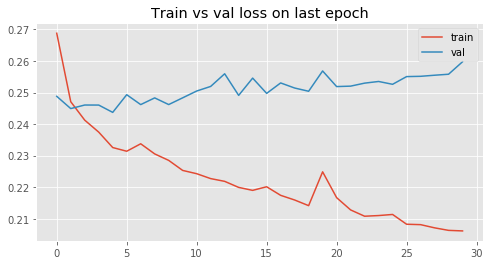

In [456]:
plt.figure(figsize = (8,4))
plt.title("Train vs val loss on last epoch")
plt.plot(running_train_loss, label = "train")
plt.plot(running_val_loss, label = "val")
plt.legend()
plt.show()

In [445]:
sub = pd.DataFrame({'ID_code': df_test.ID_code.values,
                   'target': predictions})
sub.to_csv('sub_pytorch_simplenn.csv', index = False)

In [243]:
y_train[np.arange(0,10)].shape

(10,)

In [394]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0652, -0.1257, -0.3529,  ..., -0.0391,  0.2176, -0.1040],
                      [-0.0255, -0.3264, -0.1005,  ...,  0.1810,  0.1328, -0.1319],
                      [-0.2172, -0.2330, -0.2230,  ...,  0.1334, -0.0833, -0.0727],
                      ...,
                      [-0.3240, -0.1038, -0.3555,  ..., -0.0988,  0.0431, -0.3935],
                      [-0.1193, -0.0127, -0.0562,  ...,  0.0815,  0.0255, -0.1399],
                      [-0.1967, -0.1648, -0.1256,  ...,  0.3448, -0.1251, -0.2353]],
                     device='cuda:0')),
             ('fc1.bias',
              tensor([ 0.2211, -0.1639,  0.0224, -0.2023,  0.0124, -0.1206, -0.1440, -0.2307,
                       0.1026, -0.1597,  0.1066,  0.0243, -0.6924,  0.1618, -0.2068, -0.0942,
                       0.0198, -0.0583,  0.1105,  0.0042,  0.1912,  0.0457,  0.0496,  0.0537,
                       0.0404,  0.1532,  0.2986, -0.0159, -0.1630, -0.0023,  0.0543,  0.0579

In [279]:
for i, (val_x_batch, val_y_batch) in enumerate(valloader):
    print(i, val_x_batch.shape, val_y_batch.shape)

0 torch.Size([1000, 200]) torch.Size([1000])
1 torch.Size([1000, 200]) torch.Size([1000])
2 torch.Size([1000, 200]) torch.Size([1000])
3 torch.Size([1000, 200]) torch.Size([1000])
4 torch.Size([1000, 200]) torch.Size([1000])
5 torch.Size([1, 200]) torch.Size([1])


In [293]:
sigmoid(val_output.cpu().numpy()[:,0])

array([0.49217793], dtype=float32)

In [335]:
a = 10
print(a)
b = np.arange(2)
print(b)

10
[0 1]


In [336]:
list(b)

[0, 1]

In [342]:
[b]

[array([0, 1])]